## Using FEDOT for hybrid modeling with custom model tuning

#### FEDOT version = 0.6.1

In [1]:
!pip install fedot==0.6.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m !pip install --upgrade pip


[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This tutorial was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

If you want to learn some basic things about FEDOT and time series forecasting, you can use [this notebook](3_intro_ts_forecasting.ipynb).

In [2]:
# Additional imports 
import numpy as np
import pandas as pd
from hyperopt import hp
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

# Pipeline and nodes
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline

# Data
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup

# Tasks
from fedot.core.repository.tasks import TaskTypesEnum, Task, TsForecastingParams

#Tuning
from fedot.core.pipelines.tuning.search_space import SearchSpace
from fedot.core.pipelines.tuning.unified import PipelineTuner

import warnings
warnings.filterwarnings('ignore')

import logging
logging.raiseExceptions = False

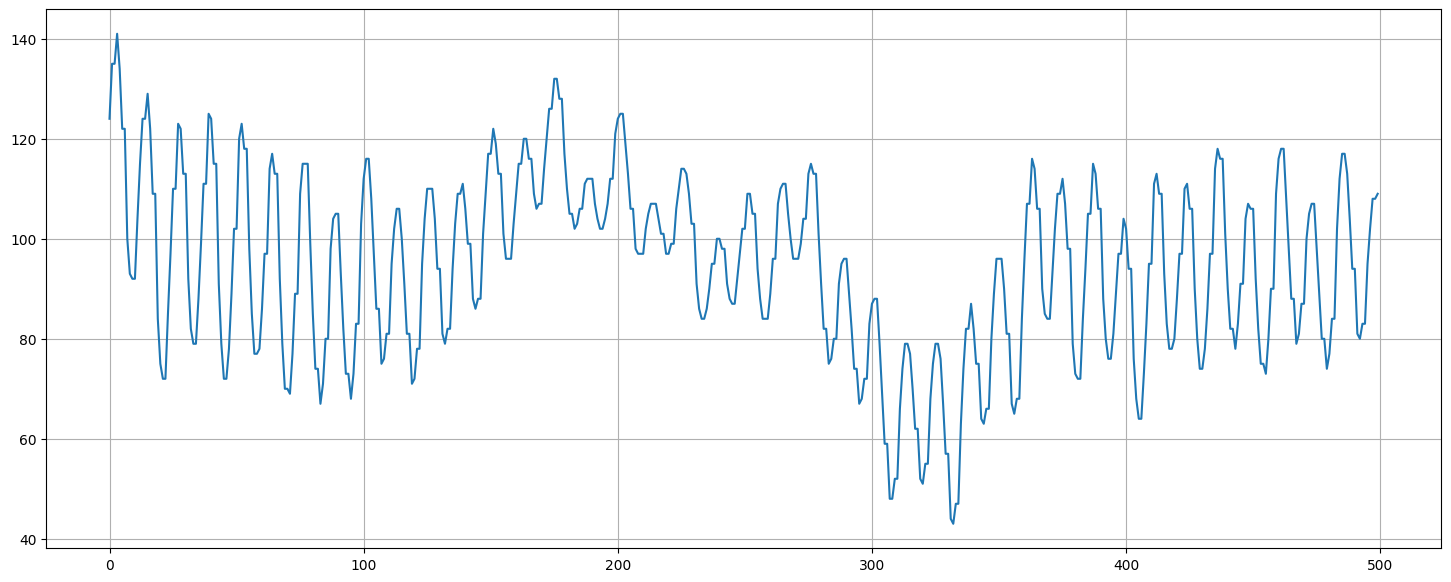

In [3]:
# Read the file
df = pd.read_csv('../data/metocean.csv')

plt.plot(np.arange(len(df['value'])), df['value'])
plt.grid()
plt.show()

# Specify forecast length
len_forecast = 50

# Got univariate time series as numpy array
time_series = np.array(df['value'])

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=len_forecast))

# Split data into train and test
train_input, predict_input = train_test_data_setup(InputData(idx=range(len(time_series)),
                                                                 features=time_series,
                                                                 target=time_series,
                                                                 task=Task(TaskTypesEnum.ts_forecasting,
                                                                           TsForecastingParams(forecast_length=len_forecast)),
                                                                 data_type=DataTypesEnum.ts))

We have a time series of sea level. Based on this time series we will conduct the case of forecasting with custom model implantation in the pipeline.

### Custom model specification

Some custom models have necessary step of fitting, but some of them such as domain specific models doesn't need fitting at all. For using with FEDOT custom model should be wrapped into function that provides fit (if it is necessary) and predict steps. Fit step returns model object, predict step returns predicted values.

In [4]:
# Let's prepare a function for imitation custom model without fitting
def domain_model_imitation_predict(fitted_model: any, idx: np.array, predict_data: np.array, params: dict):
    a = params.get('a')
    b = params.get('b')
    shape = predict_data.shape
    result = np.random.rand(*shape) * a + b
    # Available output_type's 'table', 'ts', 'image', 'text'
    return result, 'table'

# Function for custom regression model imitation (fit)
def custom_ml_model_imitation_fit(idx: np.array, features: np.array, target: np.array, params: dict):
    alpha = params.get('alpha')
    reg = Ridge(alpha=alpha)
    reg.fit(features, target)
    return reg

# Function for custom regression model imitation (predict)
def custom_ml_model_imitation_predict(fitted_model: any, idx: np.array, features: np.array, params: dict):
    res = fitted_model.predict(features)
    return res, 'table'

Including custom model into pipeline is provided by using custom parameters of node. Also there should be indicated parameters of model for tune and initial approximation for them.

In [5]:
# Let's prepare a function for pipeline with custom node without fitting
def get_domain_pipeline():
    """
        Pipeline looking like this
        lagged -> custom -> ridge
    """
    lagged_node = PrimaryNode('lagged')
    lagged_node.parameters = {'window_size': 10}

    # For custom model params as initial approximation and model as function is necessary
    custom_node = SecondaryNode('custom', nodes_from=[lagged_node])
    custom_node.parameters = {"a": -50, "b": 500, 'model_predict': domain_model_imitation_predict}

    node_final = SecondaryNode('ridge', nodes_from=[custom_node])
    pipeline = Pipeline(node_final)

    return pipeline

# Function for pipeline with custom node with fitting
def get_fitting_custom_pipeline():
    """
        Pipeline looking like this
        lagged -> custom -> ridge
    """
    lagged_node = PrimaryNode('lagged')
    lagged_node.parameters = {'window_size': 10}

    # For custom model params as initial approximation and model as function is necessary
    custom_node = SecondaryNode('custom', nodes_from=[lagged_node])
    custom_node.parameters = {'alpha': 5,
                                 'model_predict': custom_ml_model_imitation_predict,
                                 'model_fit': custom_ml_model_imitation_fit}

    node_final = SecondaryNode('lasso', nodes_from=[custom_node])
    pipeline = Pipeline(node_final)

    return pipeline

For pipeline tuning search space of custom model parameters should be specified. Hyperopt wrapper is used for that.

### Function for prediction with/without fitting custom model

In [10]:
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.repository.quality_metrics_repository import \
    MetricsRepository, RegressionMetricsEnum


def run_pipeline_tuning(pipeline_type):

    if pipeline_type == 'with_fit':
        pipeline = get_fitting_custom_pipeline()
        # Setting custom search space for tuner (necessary)
        # model and output_type should be wrapped into hyperopt
        custom_search_space = {'custom': {
            'alpha': (hp.uniform, [0.01, 10]),
            'model_predict': (hp.choice, [[custom_ml_model_imitation_predict]]),
            'model_fit': (hp.choice, [[custom_ml_model_imitation_fit]])}}
    elif pipeline_type == 'without_fit':
        pipeline = get_domain_pipeline()
        # Setting custom search space for tuner (necessary)
        # model and output_type should be wrapped into hyperopt
        custom_search_space = {'custom': {'a': (hp.uniform, [-100, 100]),
                                          'b': (hp.uniform, [0, 1000]),
                                          'model_predict': (hp.choice, [[domain_model_imitation_predict]])}}
    pipeline.fit_from_scratch(train_input)
    pipeline.print_structure()
    # Get prediction with initial approximation
    predicted_before_tuning = pipeline.predict(predict_input).predict

    replace_default_search_space = True

    # Start tuning all nodes in the pipeline 
    tuner = TunerBuilder(train_input.task)\
            .with_tuner(PipelineTuner)\
            .with_metric(RegressionMetricsEnum.MSE)\
            .with_iterations(50) \
            .with_cv_folds(None) \
            .with_validation_blocks(3) \
            .with_search_space(SearchSpace(custom_search_space=custom_search_space,
                                                                replace_default_search_space=replace_default_search_space))\
            .build(train_input)
    tuned_pipeline = tuner.tune(pipeline)
    
    # Fit pipeline on the entire train data
    pipeline.fit(train_input)
    # Predict tuned pipeline
    predicted_values = pipeline.predict(predict_input).predict
    pipeline.print_structure()

    plt.plot(np.arange(len(predicted_before_tuning[0])), predicted_before_tuning[0], label='Before tuning')
    plt.plot(np.arange(len(predicted_values[0])), predicted_values[0], label='After tuning')
    plt.plot(np.arange(len(predict_input.target)), predict_input.target, label='Real')
    plt.legend()
    plt.grid()
    plt.show()

### Case with using model with fitting 

Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [lasso, custom, lagged]}
lasso - {}
custom - {'alpha': 5, 'model_predict': <function custom_ml_model_imitation_predict at 0x0000021C4C45C670>, 'model_fit': <function custom_ml_model_imitation_fit at 0x0000021C4C45C5E0>}
lagged - {'window_size': 10}
2022-12-17 17:00:10,235 - DataSourceSplitter - Hold out validation is applied.
2022-12-17 17:00:10,236 - PipelineTuner - Hyperparameters optimization start
2022-12-17 17:00:10,372 - PipelineTuner - Initial pipeline: {'depth': 3, 'length': 3, 'nodes': [lasso, custom, lagged]}
lasso - {}
custom - {'alpha': 5, 'model_predict': <function custom_ml_model_imitation_predict at 0x0000021C4C45C670>, 'model_fit': <function custom_ml_model_imitation_fit at 0x0000021C4C45C5E0>}
lagged - {'window_size': 10} 
Initial metric: 241.516
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]2022-12-17 17:00:10,377 - build_posterior_wrapper to

 48%|███████████████████████                         | 24/50 [00:05<00:08,  3.23trial/s, best loss: 242.15145868585537]2022-12-17 17:00:15,858 - build_posterior_wrapper took 0.002002 seconds
2022-12-17 17:00:15,859 - TPE using 24/24 trials with best loss 242.151459
 50%|████████████████████████                        | 25/50 [00:05<00:06,  4.03trial/s, best loss: 242.15145868585537]2022-12-17 17:00:15,963 - build_posterior_wrapper took 0.000994 seconds
2022-12-17 17:00:15,964 - TPE using 25/25 trials with best loss 242.151459
 52%|████████████████████████▉                       | 26/50 [00:05<00:06,  3.64trial/s, best loss: 242.15145868585537]2022-12-17 17:00:16,299 - build_posterior_wrapper took 0.001005 seconds
2022-12-17 17:00:16,300 - TPE using 26/26 trials with best loss 242.151459
2022-12-17 17:00:16,309 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 377 to 240.
 54%|█████████████████████████▉                      | 27/50 [00

100%|████████████████████████████████████████████████| 50/50 [00:11<00:00,  3.80trial/s, best loss: 174.11486403209895]
2022-12-17 17:00:22,977 - PipelineTuner - Hyperparameters optimization finished
2022-12-17 17:00:22,977 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 174.115 equal or better than initial (+ 5% deviation) 253.592
2022-12-17 17:00:22,978 - PipelineTuner - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [lasso, custom, lagged]}
lasso - {'alpha': 0.08769736331202482}
custom - {'alpha': 5.023277746059172, 'model_fit': <function custom_ml_model_imitation_fit at 0x0000021C4C45C5E0>, 'model_predict': <function custom_ml_model_imitation_predict at 0x0000021C4C45C670>}
lagged - {'window_size': 32}
2022-12-17 17:00:22,979 - PipelineTuner - Final metric: 174.115
Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [lasso, custom, lagged]}
lasso - {'alpha': 0.08769736331202482}
custom - {'alpha': 5.023277746059172, 'model_fit': <function custom_

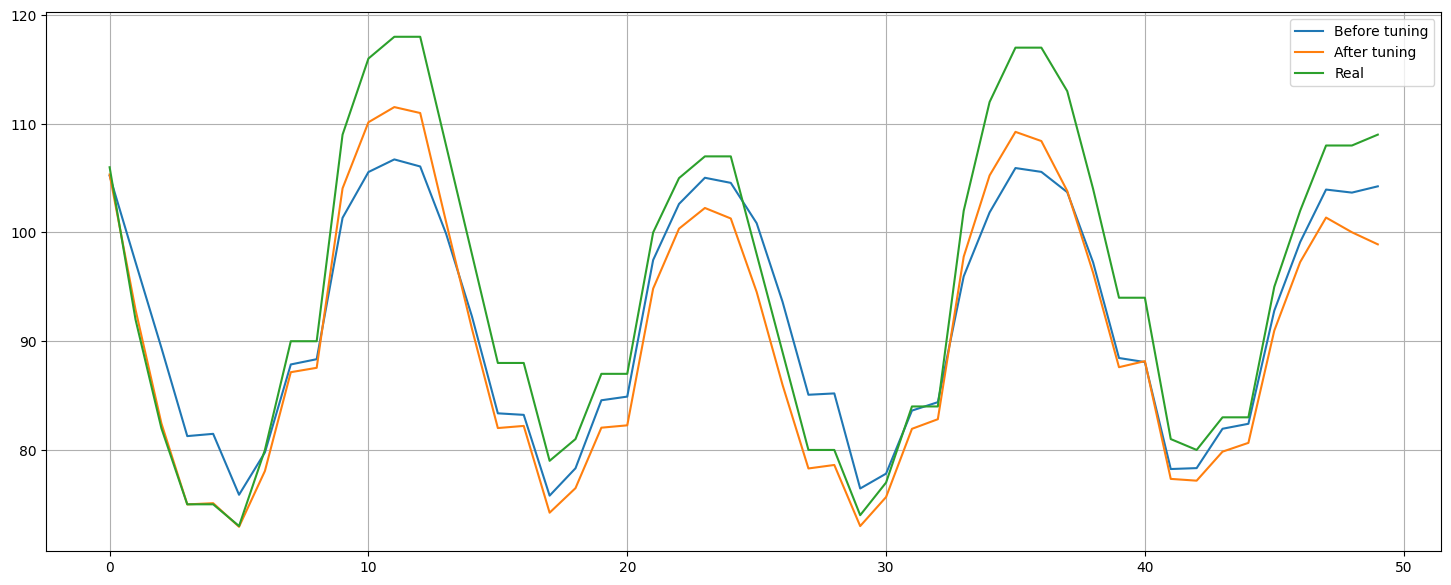

In [11]:
run_pipeline_tuning(pipeline_type='with_fit')

Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [ridge, custom, lagged]}
ridge - {}
custom - {'a': -50, 'b': 500, 'model_predict': <function domain_model_imitation_predict at 0x0000021C4C45C430>}
lagged - {'window_size': 10}
2022-12-17 17:00:23,569 - DataSourceSplitter - Hold out validation is applied.
2022-12-17 17:00:23,571 - PipelineTuner - Hyperparameters optimization start
2022-12-17 17:00:23,614 - PipelineTuner - Initial pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, custom, lagged]}
ridge - {}
custom - {'a': -50, 'b': 500, 'model_predict': <function domain_model_imitation_predict at 0x0000021C4C45C430>}
lagged - {'window_size': 10} 
Initial metric: 35055.400
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]2022-12-17 17:00:23,619 - build_posterior_wrapper took 0.000999 seconds
2022-12-17 17:00:23,620 - TPE using 0 trials
2022-12-17 17:00:23,662 - build_posterior_wrapper took 0.001002 seconds
2022-

 52%|█████████████████████████▍                       | 26/50 [00:04<00:05,  4.15trial/s, best loss: 564.3486743631228]2022-12-17 17:00:28,393 - build_posterior_wrapper took 0.001000 seconds
2022-12-17 17:00:28,394 - TPE using 26/26 trials with best loss 564.348674
2022-12-17 17:00:28,403 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 328 to 240.
 54%|██████████████████████████▍                      | 27/50 [00:04<00:05,  3.92trial/s, best loss: 564.3486743631228]2022-12-17 17:00:28,683 - build_posterior_wrapper took 0.000992 seconds
2022-12-17 17:00:28,684 - TPE using 27/27 trials with best loss 564.348674
2022-12-17 17:00:28,692 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 390 to 240.
 56%|███████████████████████████▍                     | 28/50 [00:05<00:05,  3.78trial/s, best loss: 564.3486743631228]2022-12-17 17:00:28,972 - build_posterior_wrapper took 0.001009 seconds
2

 98%|████████████████████████████████████████████████ | 49/50 [00:11<00:00,  3.54trial/s, best loss: 544.3629987700928]2022-12-17 17:00:34,950 - build_posterior_wrapper took 0.002011 seconds
2022-12-17 17:00:34,950 - TPE using 49/49 trials with best loss 544.362999
100%|█████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.02trial/s, best loss: 544.3629987700928]
2022-12-17 17:00:35,037 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 310 to 240.
2022-12-17 17:00:35,355 - PipelineTuner - Hyperparameters optimization finished
2022-12-17 17:00:35,356 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 543.593 equal or better than initial (+ 5% deviation) 36808.170
2022-12-17 17:00:35,357 - PipelineTuner - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, custom, lagged]}
ridge - {'alpha': 8.428811932274613}
custom - {'a': 55.338343702157225, 'b': 63.48504071749764, 'model_predict': 

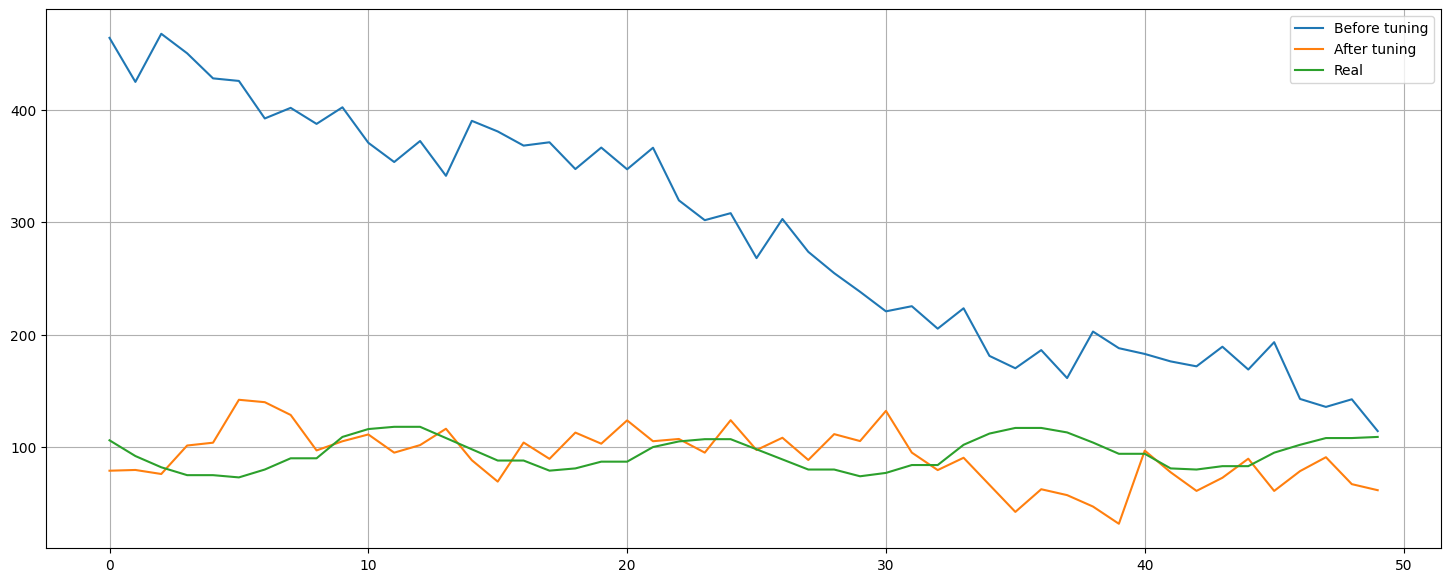

In [12]:
run_pipeline_tuning(pipeline_type='without_fit')

Thus, we demonstrated the use of imitation of custom model with FEDOT for providing the hybrid approach in composition with AutoML.